In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/My Drive/Project/torch')
!ls

data.xlsx  LSTM-Regression.ipynb  微信图片_20201029114337.png


        动力煤价格   船舶运价       电厂煤炭库存  ...       港吞吐量          原煤产量        原油
0  371.666667  18.79  1460.690625  ...  47.238710  30105.794576 -6.322500
1  376.666667  19.30  1726.240000  ...  38.231034  30105.794576  6.155882
2  385.000000  19.54  1683.373103  ...  43.193548  29379.777600  5.495217
3  385.000000  20.32  1513.747419  ...  41.366667  26803.200000  4.912632
4  387.500000  21.60  1647.192903  ...  37.509091  26375.100000  4.695000

[5 rows x 9 columns]


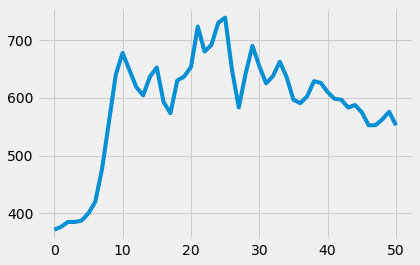

x.shape,y.shape (48, 2, 8) (48,)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
plt.style.use('fivethirtyeight')
seq_length = 2#time step
num_epochs = 200
learning_rate = 0.001
input_size = 8
hidden_size = 6
num_layers = 1
num_classes = 1
def read_data():
  '''
  read data, show and plot
  '''
  data = pd.read_excel('data.xlsx')
  data=data.iloc[:51,2:]
  label=data.iloc[:,0:1]
  print(data.head())
  plt.plot(label)
  plt.show()
  return data,label
def sliding_windows(data, seq_length):
  '''
  Output:The data form we can feed LSTM
  '''
  x = []
  y = []
  for i in range(len(data)-seq_length-1):
      _x = data[i:(i+seq_length),1:]
      _y = data[i+seq_length,0]
      x.append(_x)
      y.append(_y)
  return np.array(x),np.array(y)
def normalization(data,label):
  #normalization
  mm_x = MinMaxScaler()
  data = mm_x.fit_transform(data)
  label = mm_y.fit_transform(label)
  x, y = sliding_windows(data, seq_length)
  print('x.shape,y.shape',x.shape,y.shape)

  train_size = int(len(y) * 0.9)
  test_size = len(y) - train_size

  dataX = Variable(torch.Tensor(np.array(x)))
  dataY = Variable(torch.Tensor(np.array(y)))

  trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
  trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

  testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
  testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
  return dataX,dataY,trainX,trainY,testX,testY,mm_y

data,label=read_data() 
dataX,dataY,trainX,trainY,testX,testY,mm_y=normalization(data,label)

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    # obtain the loss function
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([43])) that is different to the input size (torch.Size([43, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, loss: 0.28593
Epoch: 10, loss: 0.23542
Epoch: 20, loss: 0.18911
Epoch: 30, loss: 0.14818
Epoch: 40, loss: 0.11431
Epoch: 50, loss: 0.08944
Epoch: 60, loss: 0.07460
Epoch: 70, loss: 0.06834
Epoch: 80, loss: 0.06684
Epoch: 90, loss: 0.06649
Epoch: 100, loss: 0.06604
Epoch: 110, loss: 0.06557
Epoch: 120, loss: 0.06518
Epoch: 130, loss: 0.06484
Epoch: 140, loss: 0.06451
Epoch: 150, loss: 0.06421
Epoch: 160, loss: 0.06392
Epoch: 170, loss: 0.06364
Epoch: 180, loss: 0.06339
Epoch: 190, loss: 0.06314


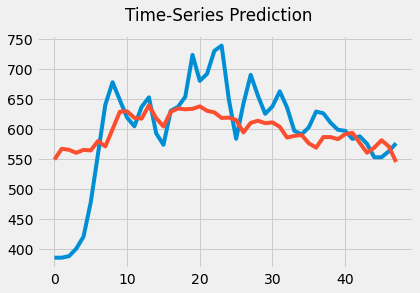

In [ ]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()
dataY_plot = np.reshape(dataY_plot, (-1,1))  
data_predict = mm_y.inverse_transform(data_predict)
dataY_plot = mm_y.inverse_transform(dataY_plot)

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()